# Exploratory Data Analysis

This notebook will go through the exploratory data analysis of the data. I will ask questions based on my learnings in research papers and explore the data.

In [47]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import sqlalchemy
from transformers import pipeline, RobertaTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import language_tool_python
import torchtext
from torchtext.data import get_tokenizer

# Adding the credentials
sys.path.append('../')
from credentials import credentials

# Making pandas tqdm
tqdm.pandas()

In [2]:
# Creating the database engine 
connector_string = f'mysql+mysqlconnector://{credentials["user"]}:{credentials["password"]}@{credentials["host"]}/AuthenticAI'
db_engine = sqlalchemy.create_engine(connector_string,echo=True)

# Connecting to the database
db_conn = db_engine.connect()

2024-01-10 21:15:26,348 INFO sqlalchemy.engine.Engine SELECT DATABASE()


SELECT DATABASE()


2024-01-10 21:15:26,350 INFO sqlalchemy.engine.Engine [raw sql] {}


[raw sql] {}


2024-01-10 21:15:26,355 INFO sqlalchemy.engine.Engine SELECT @@sql_mode


SELECT @@sql_mode


2024-01-10 21:15:26,357 INFO sqlalchemy.engine.Engine [raw sql] {}


[raw sql] {}


2024-01-10 21:15:26,361 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names


SELECT @@lower_case_table_names


2024-01-10 21:15:26,363 INFO sqlalchemy.engine.Engine [raw sql] {}


[raw sql] {}


## What is the distribution of the labels? How many student written essays are there? How many LLM generated essays? Is there an imbalance?

In [3]:
student_written_count = [i[0] for i in db_conn.execute(sqlalchemy.text('select count(*) from essays where essays.LLM_written = 0;'))][0]
llm_written_count = [i[0] for i in db_conn.execute(sqlalchemy.text('select count(*) from essays where essays.LLM_written = 1;'))][0]

2024-01-10 21:15:28,065 INFO sqlalchemy.engine.Engine BEGIN (implicit)


BEGIN (implicit)


2024-01-10 21:15:28,069 INFO sqlalchemy.engine.Engine select count(*) from essays where essays.LLM_written = 0;


select count(*) from essays where essays.LLM_written = 0;


2024-01-10 21:15:28,072 INFO sqlalchemy.engine.Engine [generated in 0.00854s] {}


[generated in 0.00854s] {}


2024-01-10 21:15:28,985 INFO sqlalchemy.engine.Engine select count(*) from essays where essays.LLM_written = 1;


select count(*) from essays where essays.LLM_written = 1;


2024-01-10 21:15:28,986 INFO sqlalchemy.engine.Engine [generated in 0.00173s] {}


[generated in 0.00173s] {}


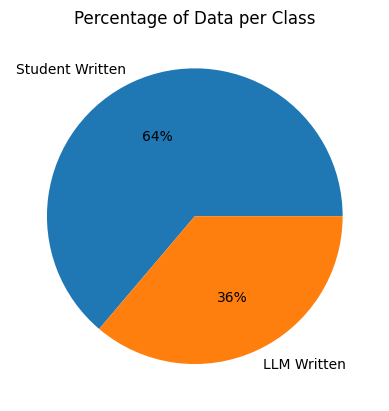

In [4]:
# Plotting the numbers in a pie chart
classes = ['Student Written','LLM Written']
data = [student_written_count, llm_written_count]

plt.pie(x=data,labels=classes,autopct='%.0f%%')
plt.title('Percentage of Data per Class')
plt.show()

## What is the mean, median, and standard deviation of the number of words per each class? Is there a significant difference?

In [5]:
word_counts = pd.DataFrame([i for i in db_conn.execute(sqlalchemy.text('select word_count, LLM_written from essays;'))])

2024-01-10 21:15:31,395 INFO sqlalchemy.engine.Engine select word_count, LLM_written from essays;


select word_count, LLM_written from essays;


2024-01-10 21:15:31,400 INFO sqlalchemy.engine.Engine [generated in 0.00498s] {}


[generated in 0.00498s] {}


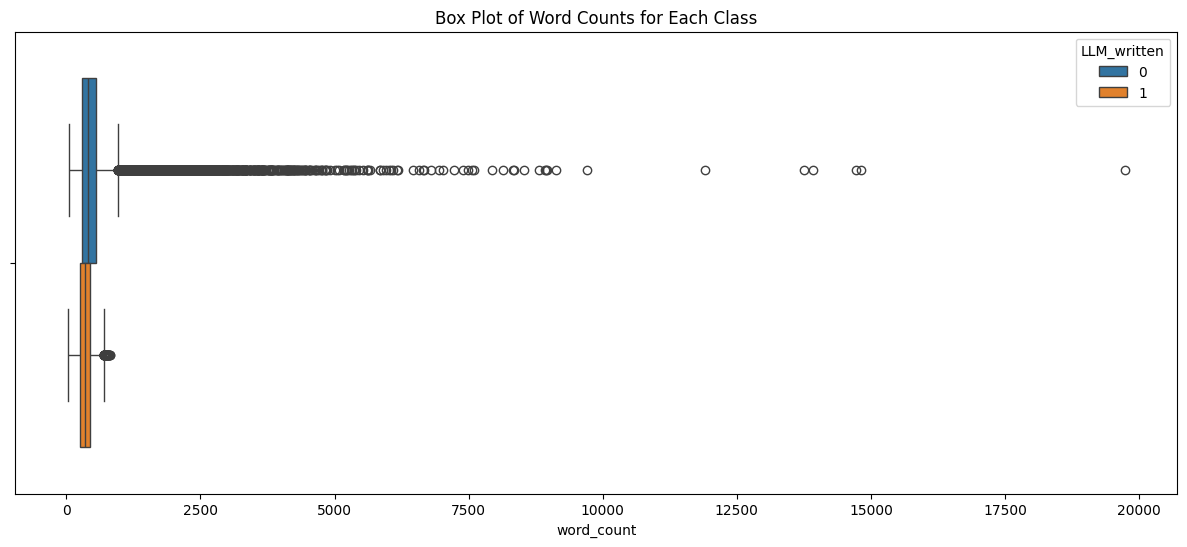

In [6]:
plt.figure(figsize=(15,6))
sns.boxplot(data=word_counts,x='word_count',hue='LLM_written')
plt.title('Box Plot of Word Counts for Each Class')
plt.show()

Figure isn't great due to various outliers in the student written essays. Perhaps plotting distributions could help.

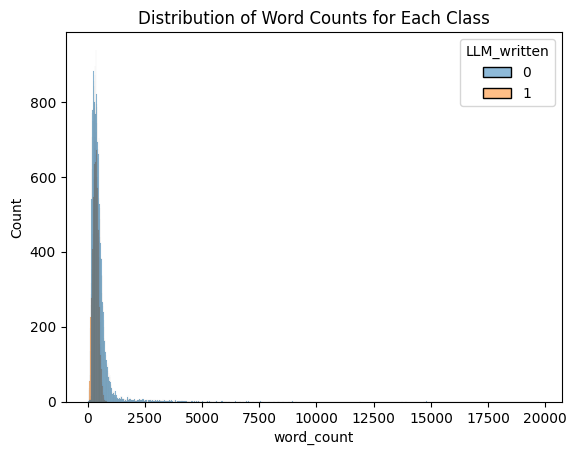

In [7]:
plt.title('Distribution of Word Counts for Each Class')
sns.histplot(data=word_counts,x='word_count',hue='LLM_written')
plt.show()

This plot is a bit better, but not by much. It illustrates that the distribution of student written essays is skewed ,and it looks as the central statistic is bigger. However, the student essays seem to have more standard deviation and variance.

In [8]:
print('Student Written Essay Descriptive Statistics')
print(word_counts[word_counts['LLM_written'] == 0]['word_count'].describe())
print()
print('LLM Written Essay Descriptive Statistics')
print(word_counts[word_counts['LLM_written'] == 1]['word_count'].describe())

Student Written Essay Descriptive Statistics
count    31856.000000
mean       500.700402
std        515.048760
min         48.000000
25%        284.000000
50%        401.000000
75%        558.000000
max      19729.000000
Name: word_count, dtype: float64

LLM Written Essay Descriptive Statistics
count    18073.000000
mean       346.715985
std        124.453252
min         25.000000
25%        258.000000
50%        345.000000
75%        433.000000
max        821.000000
Name: word_count, dtype: float64


The table confirms suspicions that the student written essays tend to have a higher word count than the LLM written essays. If we look at the statistics, we can see that the median number of words for the student written essays is 56 words than the LLM written essays. Furthermore, the maximum number of words in a student written essay is 19729, which is much larger than the maximum number of words in the LLM written essays (821). While the standard deviation for the student written essays is much higher, the median and max count confirm the fact that student written essays tend to have higher word count than LLM written essays. This is a good feature to have for the classical ML models. 

## Can a LLM detect whether an essay is LLM Generated?

In this section, I want to see if a LLM can detect whether an essay was written by a LLM. This question stems from the paper "Will ChatGPT get you caught? Rethinking of Plagiarism Detection". In this paper, the researchers showed that ChatGPT was able to achieve an accuracy of over 92% in detecting whether an essay was written by ChatGPT. However, one cavet of the paper was that the dataset was composed of essays written only by ChatGPT. Furthermore, OpenAI's API is not free, hence I won't be able to test this result and see how it works on my dataset. Fortunately, in the research paper "Release Strategies and the Social Impacts of Language Models", the researchers were able to fine-tune a RoBERTA model to get an accuracy of approximately 95% of this task. An important thing to mention here is that the model was fine-tuned on outputs from GPT-2; however, the model is open source on Hugging Face and free of charge, thus it would be a good idea to test this theory.

In short, in this section, I utilize the RoBERTA Base OpenAI Detector by OpenAI (available on Hugging Face) to see if a LLM can detect whether an essay was written by a LLM. The results of this experiment will be interesting as this model has been trained to detect text written by GPT-2 ,and my data contains essays written from a variety of LLMs.

In [9]:
# Getting the model and tokenizer
detector = pipeline("text-classification","roberta-base-openai-detector")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Getting the text and corresponding labels
text_and_labels = pd.DataFrame([i for i in db_conn.execute(sqlalchemy.text('select essay, LLM_written from essays;'))])

2024-01-10 21:15:56,310 INFO sqlalchemy.engine.Engine select essay, LLM_written from essays;


select essay, LLM_written from essays;


2024-01-10 21:15:56,355 INFO sqlalchemy.engine.Engine [generated in 0.04732s] {}


[generated in 0.04732s] {}


In [11]:
# A function to see the length of the tokenized text
# RoBERTA has a limit of 512 tokens and breaks if you provide more.
# I need to choose the examples with <= 512 tokens
def num_of_tokens(text:str) -> int:
    tokenized_text = tokenizer(text)['input_ids']
    return len(tokenized_text)

In [13]:
# Getting the tokenized text for each text
text_and_labels['token_count'] = text_and_labels['essay'].progress_apply(num_of_tokens)
text_and_labels.head()

100%|██████████| 49929/49929 [07:18<00:00, 113.93it/s]


,essay,LLM_written,token_count
0,"Dear State Senator,\n\nI'm writting to you tod...",1,343
1,"Uh, hi! So, like, summers are, like, awesome r...",1,449
2,"When peoples ask for advices, they sometimes t...",1,383
3,I think art edukation is super impotent for ki...,1,388
4,I think we should totally switch to renewable ...,1,350


In [14]:
# Selecting the examples that match the token count
valid_examples = text_and_labels[text_and_labels['token_count'] <= 512]
valid_examples.head()

,essay,LLM_written,token_count
0,"Dear State Senator,\n\nI'm writting to you tod...",1,343
1,"Uh, hi! So, like, summers are, like, awesome r...",1,449
2,"When peoples ask for advices, they sometimes t...",1,383
3,I think art edukation is super impotent for ki...,1,388
4,I think we should totally switch to renewable ...,1,350


In [15]:
# Checking how many examples there are
valid_examples.shape

(31095, 3)

In [16]:
# Running the model through 31000 examples takes some time since 
# I am running it on CPU. It takes about 2 mins to get predictions on 
# 100 examples. Will run on 500 randomly selected examples (Stratified by LLM_written) 
# and make prediction. 
_, sample = train_test_split(valid_examples,test_size=1000,random_state=42,shuffle=True,stratify=valid_examples['LLM_written'])
sample['LLM_written'].value_counts()

LLM_written
0    569
1    431
Name: count, dtype: int64

In [17]:
# Getting the predictions
predictions = detector(sample['essay'].tolist())

In [18]:
# Getting the list of predictions
pred_list = [0 if pred['label'] == 'Real' else 1 for pred in predictions]
sample['predictions'] = pred_list
sample.head()

,essay,LLM_written,token_count,predictions
26498,"In the article ""Driverless Cars Are Coming"" I ...",0,505,0
18719,"Studying Venus can be a good thing to do, you ...",0,178,0
24920,Grades in schools\n\nGrades and sports are big...,0,275,0
11900,In the 21st millions of people rely on cars as...,0,274,0
14931,I think you should join the Seagoing Cowboys. ...,0,441,0


In [19]:
# Calculating the accuracy
accuracy = accuracy_score(sample['LLM_written'],sample['predictions'])
print(f'Accuracy: {accuracy * 100}%')

Accuracy: 86.3%


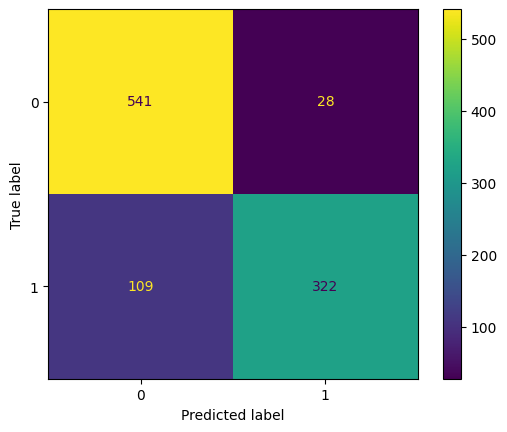

In [20]:
# Looking at a confusion matrix
matrix = confusion_matrix(sample['LLM_written'],sample['predictions'])
display = ConfusionMatrixDisplay(matrix)
display.plot()
plt.show()

In [21]:
# Accuracies for each class
print(f'P(Y = 0 | X = student written essay) = {matrix[0][0] / (matrix[0][0] + matrix[0][1])}')
print(f'P(Y = 1 | X = LLM written essay) = {matrix[1][1] / (matrix[1][1] + matrix[1][0])}')

P(Y = 0 | X = student written essay) = 0.9507908611599297
P(Y = 1 | X = LLM written essay) = 0.7470997679814385


Conclusion: The LLM was able to detect whether an essay is LLM Generated.

After taking a sample of 1000 randomly selected examples (stratified by class label), I found that the LLM was able to make correct predictions at an accuracy of 86%. While this is a drop-off from the paper's accuracy (95%), this can attributed to the diversity in the essays. No essay was from GPT-2, rather more powerful models such as GPT 3.5 and LLama 2 were used. Thus, it is expected for an accuracy drop off to occur. 

The confusion matrix is able to convey 2 key things: 1) the model is to detect Y = 0 (essay was written by a student) at a very high accuracy, with very few false positives and 2) the model does "struggle" to detect Y = 1 (essay was written by a LLM) as there are many more false negatives. However, this behavior isn't surprising since the LLM used here (RoBERTa base OpenAI Detector) was trained to predict outputs from GPT-2. The LLMs that wrote the essays in the dataset are far more advanced, thus making it much harder for RoBERTa base OpenAI Detector to detect text written by them. All things considered, it would be useful to incorporate this behavior as a feature for classical ML models since RoBERTa base OpenAI Detector performs decently well in this prediction task. 

## Can the number of grammatical errors affect prediction?

In research papers, researchers tended to use human evaluators to see if an essay was written by a LLM or a human. The researchers found that the human evaluators were able to utilize the number of grammatical mistakes as a "predictor". They found that the more grammatical mistakes a piece of text hand, the higher the chance that it was written by a person. In this section, I ask the following question: Can the number of grammatical mistakes serve as a predictor in my task?

In [22]:
# Setting up language_tool_python locally
tool = language_tool_python.LanguageTool('en-US',config={'cacheSize': 1000})

In [23]:
# Creating a function to build a column that checks how many grammer errors are present
def grammer_error_count(text:str) -> int:
    errors = tool.check(text)
    return len(errors)

In [24]:
# Getting the essays and labels
text_and_labels = pd.DataFrame([i for i in db_conn.execute(sqlalchemy.text('select essay, LLM_written from essays;'))])
text_and_labels.head()

2024-01-10 21:58:00,065 INFO sqlalchemy.engine.Engine select essay, LLM_written from essays;


select essay, LLM_written from essays;


2024-01-10 21:58:00,068 INFO sqlalchemy.engine.Engine [cached since 2524s ago] {}


[cached since 2524s ago] {}


,essay,LLM_written
0,"Dear State Senator,\n\nI'm writting to you tod...",1
1,"Uh, hi! So, like, summers are, like, awesome r...",1
2,"When peoples ask for advices, they sometimes t...",1
3,I think art edukation is super impotent for ki...,1
4,I think we should totally switch to renewable ...,1


In [25]:
# Taking a sample of the data since it would take a while to do the entire dataset
_, sample = train_test_split(text_and_labels,test_size=5000,random_state=42,shuffle=True,stratify=text_and_labels['LLM_written'])
sample['LLM_written'].value_counts()

LLM_written
0    3190
1    1810
Name: count, dtype: int64

In [26]:
sample['grammar_error_count'] = sample['essay'].progress_apply(grammer_error_count)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [25:31<00:00,  3.26it/s]  


In [27]:
# Getting the data of the different classes
student = sample[sample['LLM_written'] == 0]
llm_written = sample[sample['LLM_written'] == 1]

In [28]:
# Looking at the descriptive statistics for the grammar errors
print('Student Grammatical Errors')
print(student['grammar_error_count'].describe())
print()
print('LLM Grammatical Errors')
print(llm_written['grammar_error_count'].describe())

Student Grammatical Errors
count    3190.000000
mean       17.138558
std        21.626514
min         0.000000
25%         7.000000
50%        12.000000
75%        21.000000
max       441.000000
Name: grammar_error_count, dtype: float64

LLM Grammatical Errors
count    1810.00000
mean        1.18453
std         2.84250
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max        45.00000
Name: grammar_error_count, dtype: float64


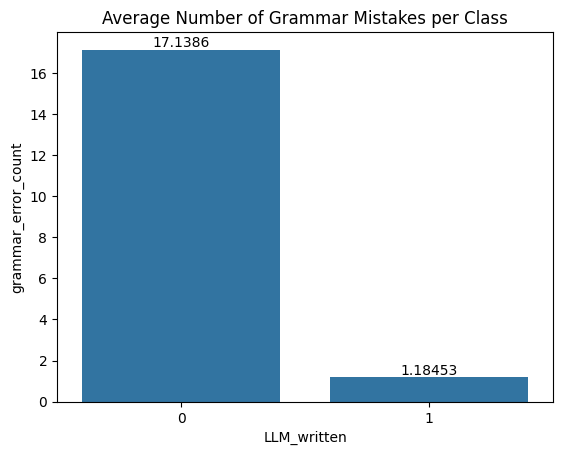

In [29]:
plt.title('Average Number of Grammar Mistakes per Class')
plot = sns.barplot(data=sample,x='LLM_written',y='grammar_error_count',errorbar=None)
for i in plot.containers:
    plot.bar_label(i,)
plt.show()

Conclusion:

In a sample of 5000 examples, I found that ,on average, the student written essays would have approximately 15-16 more grammatical mistakes. As the plot shows, the student written essays,on average, have a lot more grammar errors than the LLM written ones. If we observe the descriptive statistics table, we can see that the mean and median are much higher for much higher for the student written essays. Furthermore, there is much bigger standard deviation, as one essay was found to have 441 grammar mistakes. This analysis provides confidence that the number of grammar mistakes is a good predictor of whether an essay was written by a LLM. Even in this small sample, it is clear that student written essays have a higher number of grammatical errors than a LLM written essay. For classical ML approaches, I should include this as a feature.

In this notebook, I performed an in-depth analysis on the overall differences between the 2 classes in terms of essays. My findings will be used to build features for a classical ML solution. However, I haven't properly analyzed the physical text. This will be done in a new notebook as this notebook is getting large. 

In [60]:
# Closing connections and deleting the engine
db_conn.close()
db_engine.dispose()

2024-01-10 23:28:49,843 INFO sqlalchemy.engine.Engine ROLLBACK


ROLLBACK
